# Agglomerative clustering of phylogenies

In [1]:
import copy
import heapq
from collections import OrderedDict
import graphviz
import itertools
import random

Let's define an edge-labeled tree data structure whose nodes contain maps from children to distance from parent.

In [2]:
class Node:
    def __init__(self, **children):
        self.children = children

By convention assume trees contain all nodes and are preorder sorted.

In [3]:
tree = OrderedDict()
tree["a"] = Node(b=1, c=2)
tree["b"] = Node()
tree["c"] = Node(d=3, e=4)
tree["d"] = Node()
tree["e"] = Node()

In [4]:
def plot_tree(tree):
    dot = graphviz.Digraph()
    for parent, node in tree.items():
        for child, distance in node.children.items():
            dot.edge(parent, child, label=str(distance))
    return dot

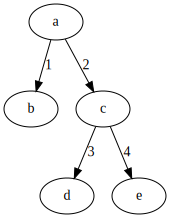

In [5]:
plot_tree(tree)

Now we define an $O(n \log(n))$ time greedy algorithm to collapse edges until the tree is sufficiently small.

In [6]:
def agglomerate(tree, max_num_nodes):
    """
    Condenses a distance tree by greedily merging nodes with least value
    under the error-minimizing objective function::

        value(node) = num_mutations(node) * weights(node)

    Returns a restricted set of clade names.
    """
    tree = copy.deepcopy(tree)
    num_pruned = len(tree) - max_num_nodes
    print(f"Agglomerating {len(tree)} -> {max_num_nodes}")
    if num_pruned < 0:
        return tree

    # Initialize weights.
    # Give weight 1 to each leaf node.
    weights = {name: 0 if node.children else 1 for name, node in tree.items()}
    # Add weights for each MRCA query. 
    cum_weights = weights.copy()
    for parent, node in reversed(tree.items()):
        num_ancestors = sum(cum_weights[child] for child in node.children)
        cum_weights[parent] += num_ancestors
        for child in node.children:
            weights[parent] += cum_weights[child] * (num_ancestors - cum_weights[child])
    # Check total weight.
    total_weight = sum(weights.values())
    num_leaves = sum(1 for node in tree.values() if not node.children)
    assert total_weight == num_leaves ** 2
    
    # Construct a mutable parents map.
    parents = {}
    for parent, node in tree.items():
        for child in node.children:
            parents[child] = parent
    
    # Define the loss function
    def get_loss(child):
        parent = parents[child]
        distance = tree[parent].children[child]
        return weights[child] * distance

    # Greedily agglomerate edges.
    heap = [(get_loss(c), c) for p, node in tree.items() for c in node.children]
    heapq.heapify(heap)
    for step in range(num_pruned):
        # Find the edge with lowest loss.
        stale_loss, child = heapq.heappop(heap)
        loss = get_loss(child)
        while loss != stale_loss:
            # Reinsert edge whose loss was stale.
            stale_loss, child = heapq.heappushpop(heap, (loss, child))
            loss = get_loss(child)

        # Agglomerate this edge.
        child_node = tree.pop(child)
        parent = parents.pop(child)
        weights[parent] += weights.pop(child)  # makes the parent loss stale
        pc_distance = tree[parent].children.pop(child)
        for grandchild, cg_distance in child_node.children.items():
            tree[parent].children[grandchild] = pc_distance + cg_distance
            assert parents[grandchild] == child
            parents[grandchild] = parent
    assert len(tree) == max_num_nodes
    return tree


Agglomerating 5 -> 4


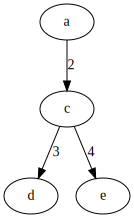

In [7]:
plot_tree(agglomerate(tree, 4))

## Test on long chain graphs

In [8]:
def gensym(n):
    assert n >= 0
    n += 1
    result = ""
    while n:
        result += "abcdefghijklmnopqrstuvwxyz"[n % 26]
        n //= 26
    return result
        
print([gensym(n) for n in [0, 1, 10, 100, 1000, 10000]])

['b', 'c', 'l', 'xd', 'nmb', 'ruo']


In [9]:
def create_chain(length, width=2):
    names = map(gensym, itertools.count())
    tree = OrderedDict()
    parent = next(names)
    tree[parent] = Node()
    for _ in range(length):
        for _ in range(width):
            child = next(names)
            tree[parent].children[child] = 1
            tree[child] = Node()
        parent = child
    return tree

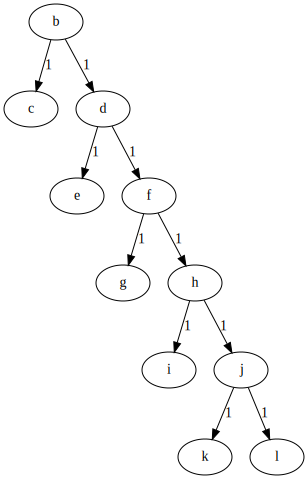

In [10]:
plot_tree(create_chain(5))

Agglomerating 201 -> 10


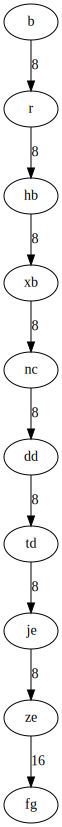

In [11]:
plot_tree(agglomerate(create_chain(100), 10))

Agglomerating 2001 -> 10


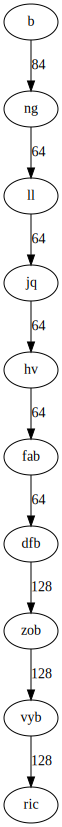

In [12]:
plot_tree(agglomerate(create_chain(1000), 10))

Agglomerating 200001 -> 10
CPU times: user 5.55 s, sys: 122 ms, total: 5.68 s
Wall time: 5.78 s


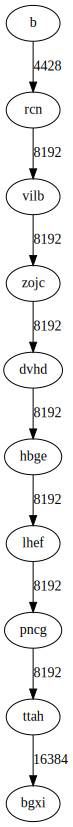

In [13]:
%%time
plot_tree(agglomerate(create_chain(100000), 10))

## Test on large balanced trees

In [14]:
def create_balanced(depth, width=2):
    names = map(gensym, itertools.count())
    tree = OrderedDict()
    parent = next(names)
    tree[parent] = Node()
    
    def add_children(parent, depth):
        if depth:
            for _ in range(width):
                child = next(names)
                tree[parent].children[child] = 1
                tree[child] = Node()
                add_children(child, depth - 1)
                
    add_children(parent, depth)
    return tree

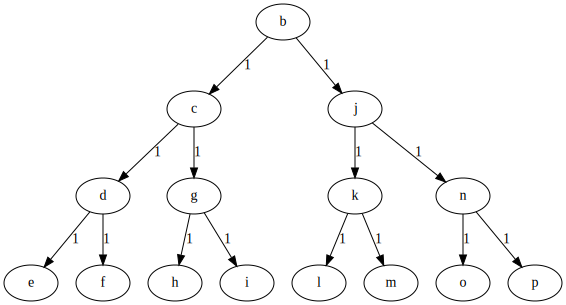

In [15]:
plot_tree(create_balanced(3))

Agglomerating 63 -> 10


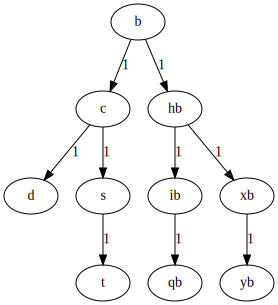

In [16]:
plot_tree(agglomerate(create_balanced(5), 10))

Agglomerating 262143 -> 10
CPU times: user 7.56 s, sys: 153 ms, total: 7.71 s
Wall time: 7.73 s


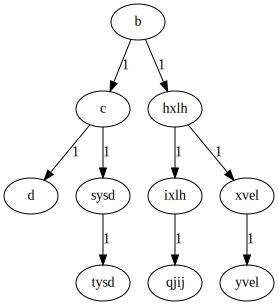

In [17]:
%%time
plot_tree(agglomerate(create_balanced(17), 10))

## Test on random trees

In [18]:
def try_create_random(max_size, prob):
    names = map(gensym, itertools.count())
    tree = OrderedDict()
    parent = next(names)
    tree[parent] = Node()
    
    def add_children(parent):
        while random.random() < prob and len(tree) < max_size:
            child = next(names)
            tree[parent].children[child] = 1
            tree[child] = Node()
            add_children(child)
                
    add_children(parent)
    return tree

def create_random(size, prob=0.5, seed=20220120):
    random.seed(seed)
    tree = OrderedDict()
    while len(tree) < size:
        tree = try_create_random(size, prob)
        print(".", end="", flush=True)
    return tree

.....

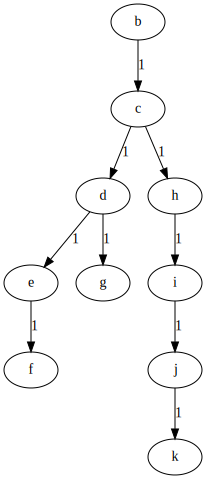

In [19]:
plot_tree(create_random(10))

..................................Agglomerating 1000 -> 10


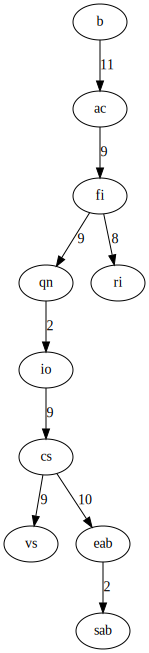

In [20]:
plot_tree(agglomerate(create_random(1000), 10))

.............................................................................................................................................................................................................................................................Agglomerating 100000 -> 10
CPU times: user 2.68 s, sys: 118 ms, total: 2.8 s
Wall time: 2.81 s


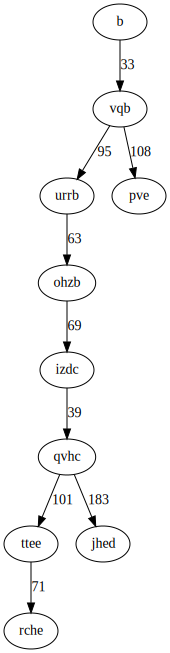

In [21]:
%%time
plot_tree(agglomerate(create_random(100000), 10))